## TTA in Phosphorescent OLEDs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import random
#plt.rcParams['figure.dpi'] = 200
%matplotlib widget

coulomb = 1.60217662E-19
#plt.rcParams['figure.figsize'] = [8, 4]
experimental = np.loadtxt('experimental_PT0EP-CBP.txt')
experimental = experimental[1:]
y_exp    = experimental[:,1]/experimental[:,1][0]
x_exp    = experimental[:,0]

x0 = experimental[0][0]
y0 = experimental[0][1]
xf = experimental[:,0][-1]

tau_t    = 65*1E-6                    # s
q        = 1*coulomb                  # electron charge
k_tt     = 3E-14                      # cm^3/s
d        = 0.8*1E-3*(k_tt*tau_t**2)/(4*q)                     # thickness of the exciton formation zone cm
kappa_tt = 2.5E-32                    # cm^6/s
J0       = 1E3*4*q*d/(k_tt*tau_t**2)  # mA/cm^2
J        = np.linspace(x0,xf,2000) # Current density mA/cm^2


##### Analytic dexter tta ####
def tta_dexter_analytic(J):
    return (J0/(4*J))*(np.sqrt(1+8*(J/J0)) -1)
############################

##### Traditional Model ####
def tta_dexter(j): 
    # aT^2 + b*T + G*c = 0
    j = j*1E-3 #mA to A
    a = 1
    b = (2/(k_tt*tau_t))
    c = -(2/k_tt)
    G = j/(q*d)
    T = [x.real for x in np.roots([a,b,G*c]) if x.imag == 0 and x.real >=0][0]
    EFF = T/(G*tau_t)
    return EFF
############################


##### New Model ####
def tta_forster(j,param): 
    # aT^3 + 0*T^2 + b*T + G*c = 0
    j = j*1E-3 #mA to A
    a = -0.5*param
    b = -1/tau_t
    c =  1
    G = j/(q*d)
    T = [x.real for x in np.roots([a,0,b,G*c]) if x.imag == 0 and x.real >=0][0]
    EFF = T/(G*tau_t)
    return EFF
############################

0.0015691080314255961 1.404040404040404e-32 0.9722222222222222


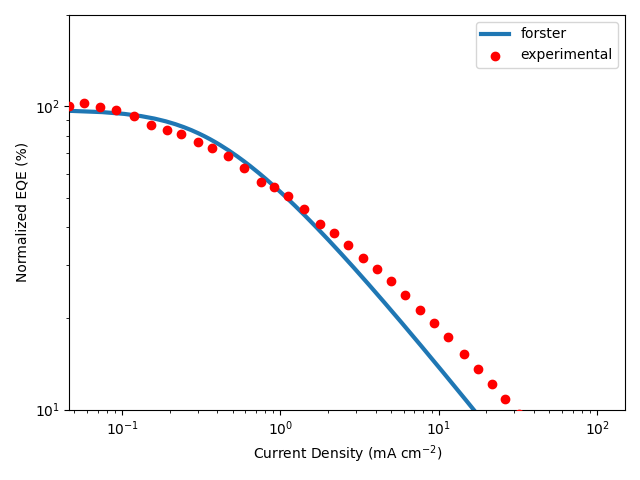

In [6]:
fig, ax = plt.subplots(1,1)
'''
#fitting 1 param only
def fitting(param_arr,x_exp,y_exp,func):
    mse_ar = []
    for param in param_arr:
        try_y = np.array([func(x,param) for x in x_exp])
        try_y = try_y/try_y[0]
        MSE   = np.mean(np.square(y_exp - try_y))
        mse_ar.append(MSE)
        ax.plot(x_exp,100*try_y,'--k') #,label=str(param),lw=2)
    indx = np.argmin(mse_ar)
    return param_arr[indx]#,mse_ar[indx]
'''
#fitting 2 parameters
def fitting(p1_arr,p2_arr,x_exp,y_exp,func):
    mse_ar = []
    for p2 in p2_arr:
        for p1 in p1_arr:
            try_y = np.array([func(x,p1) for x in x_exp])
            try_y = p2*try_y
            MSE   = np.mean(np.square(y_exp - try_y))
            #noise 
            #noise = [x*((-1)**(random.randint(0, 1)))*np.random.normal(1,1E-5,1) for x in y_exp]
            #MSE   = np.mean(np.square(y_exp - try_y +noise ))
            mse_ar.append([MSE,p1,p2])
            #ax.plot(x_exp,100*try_y,'--k') #,label=str(param),lw=2)
    indx = np.argmin(np.array(mse_ar)[:,0])
    return mse_ar[indx][0], mse_ar[indx][1],mse_ar[indx][2]

rms,best_param_1,best_param_2 = fitting(np.linspace(1E-32,41E-32,100),np.linspace(0.95,1,10),x_exp,y_exp,tta_forster)
print(rms,best_param_1,best_param_2)

analytic = tta_dexter_analytic(J)
dexter   = np.array([tta_dexter(j) for j in J])
forster  = best_param_2*np.array([tta_forster(j,best_param_1) for j in J])

#normalizing the data
analytic = analytic/analytic[0]
dexter   = dexter/dexter[0]
#forster  = forster/forster[0]
analytic = analytic/analytic[0]

#ax.plot(J,100*analytic,label='analytic',lw=6)
#ax.plot(J,100*dexter  ,label='dexter'  ,lw=3)
ax.plot(J,100*forster ,label='forster' ,lw=3)
ax.scatter(experimental[:,0],100*y_exp ,label='experimental',c='r',zorder=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([x0, 150])
ax.set_ylim([10, 200])
ax.set_xlabel('Current Density (mA cm$^{-2}$)')
ax.set_ylabel('Normalized EQE (%)')
ax.legend()
plt.tight_layout()
plt.show()
